# Advanced Image Processing (TM11005)
*Week 3: Machine learning and Pattern Recognition
Exercise 1, Lecture 2: Feature extraction*

@author: Martijn Starmans

In this exercise, you will learn all about feature extraction. The following
features will be covered:
    - Histogram
    - Gaussian based filters
    - Shape
    - Gray level matrices
    - Local binary paterns

## DATA
We will make of MR scans of patients with Low Grade Glioma (LGG)
from:
    https://wiki.cancerimagingarchive.net/display/Public/LGG-1p19qDeletion
    https://arxiv.org/pdf/1611.06939.pdf
    https://clincancerres.aacrjournals.org/content/25/24/7455.abstract

Description:
    Low Grade Glioma's (LGGs) are a specific group of cancerous brain tumors.
    Research has shown that patients with a specific genetic mutation, the
    1p/19q co-deletion, have a better survival and prognosis than patients
    who do not have this mutation.

The genetic status of a patient can only
    be obtained after taking a biopsy, followed by genetic sequencing. This
    procedure is invasive, brings risks to the patients and relatively high
    in costs.

There is therefore a major interest in trying to predict the 1p19q status
    solely based on MR scans. You are also going to try this the coming week.

This dataset consists of two MR scans per patiet (T1 and T2) plus a
    segmentation of the three middle slices of the tumor on the T2.

## Important Note
We will use the word "labels" in two contexts.

Each feature has a specific name, for example histogram_mean. We will refer
to the names of features as feature_labels.

We will encounter several datasets with various objects. These objects often
corresponds with patients, e.g. the dataset with brain MRI scans from various
patients. These patients also have "labels": these correspond to the class the
objects belongs to. For example, for the LGG dataset, each patient has the
label 0 or 1, indicating whether they have the 1p/19q co-deletion or not.

## **Handing in your answers**
For each exercise, you have to hand in answers to questions, and
for some also the code. Hence please only hand in two files in total
for this exercise set:

- Code.py (or .docx): a Python script / Text file containing all the code you are requested to hand in.
- Answers.docx (or .PDF): a text file with the answers to the
questions (plots, text, ...).

**Important Note:** You only have to make exercise 1, 2, 3 and 4 OR 5, plus the questions in those
sections.

## Intro
First, we will install the aiptoolbox package, which we created for this course with some useful functions and example data.

In [ ]:
# Let's first install the neccesary packages
!pip install numpy pandas SimpleITK scikit-image natsort scikit-learn seaborn PREDICT matplotlib

# NOTE: if you get an error when installing PREDICT concerning pywavelets,
# you can just negate it

# Install the toolbox we made for this course
!pip install -q --upgrade git+https://github.com/MStarmans91/aiptoolbox.git

     |████████████████████████████████| 47.4MB 94kB/s 
     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 163kB 38.9MB/s 
     |████████████████████████████████| 1.9MB 45.7MB/s 
     |████████████████████████████████| 4.3MB 22.8MB/s 
     |████████████████████████████████| 112kB 57.7MB/s 
     |████████████████████████████████| 552kB 55.8MB/s 
  Created wheel for phasepack: filename=phasepack-1.5-cp36-none-any.whl size=26984 sha256=188b81bb8d1a756acffe172398c17feb49370e5eeceeb965108cb4ba248852ee
  Stored in directory: /root/.cache/pip/wheels/70/b3/0a/eba59071a075d1192016960030f2b52751f23adfb260a3db93
Successfully built phasepack
ERROR: predict 3.1.13 has requirement PyWavelets<=1.0.0,>=0.4.0, but you'll have pywavelets 1.1.1 which is incompatible.
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
# Start your script ALWAYS by importing the libraries you need
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import SimpleITK as sitk
from skimage.feature import greycomatrix, greycoprops
import skimage.filters
from skimage.exposure import rescale_intensity
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb
import os

# Today, we will use the PREDICT package to calculate some features
from PREDICT.imagefeatures import histogram_features as hf
from PREDICT.imagefeatures import shape_features as sf
from PREDICT.imagefeatures import texture_features as tf
from PREDICT.helpers import image_helper as ih
from PREDICT.helpers import contour_functions as cf

# Lastly, load the package we made specifically for this course and installed in the block above
import aip

# Note: you may get a warning from sklearn.feature_selection.base, which you can neglect

/usr/local/lib/python3.6/dist-packages/phasepack/tools.py:14: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  'fftpack' module for 2D Fourier transforms.""")
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## 0. Loading images
We will first load the T2-weighted MRI scan of a patient of the LGG study
in Python with SimpleITK and convert it to a numpy array.

In [ ]:
# Get an overview of the full LGG dataset and the labels
LGG_data, LGG_labels = aip.list_data()

patient_ids = LGG_data.keys()
for pid in patient_ids:
    print(f'{pid}: {LGG_data[pid]}.')

print(LGG_labels)

LGG-104: {'T1_image': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-104/T1.nii.gz', 'T2_image': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-104/T2.nii.gz', 'Segmentation_full': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-104/Full_segmentation.nii.gz', 'Segmentation_slices': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-104/Segmentation.nii.gz', 'T1_metadata': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-104/00000_T1.dcm', 'T2_metadata': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-104/00000_T2.dcm'}.
LGG-246: {'T1_image': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-246/T1.nii.gz', 'T2_image': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-246/T2.nii.gz', 'Segmentation_full': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-246/Full_segmentation.nii.gz', 'Segmentation_slices': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG-246/Segmentation.nii.gz', 'T1_metadata': '/usr/local/lib/python3.6/dist-packages/aip/data/LGG

In [ ]:
# Let's load the T2 MRI of patient LGG-104
LGG_104_T2 = LGG_data['LGG-104']['T2_image']
T2 = sitk.ReadImage(LGG_104_T2)
T2_array = sitk.GetArrayFromImage(T2)

# Let's check the dimensions of both the original image and of the array
print('Shape image: ' + str(T2.GetSize()))
print('Shape array: ' + str(T2_array.shape))

Shape image: (256, 256, 60)
Shape array: (60, 256, 256)


This is actually a 3-D image, consisting of 60 slices with 256x256 pixels.
Note that the GetArrayFromImage function has flipped the order of the axes.
Let us therefore define a new function that does the flipping correctly
This function is also in the AIP_functions package.

In [ ]:
def GetArrayFromImageC(image):
    image = sitk.GetArrayFromImage(image)
    image = np.transpose(image, [2, 1, 0])
    return image

**NOTE:** Please make sure you always use this function to convert an ITKImage
to an array in all your exercises!

Now the shapes will be the same

In [ ]:
T2_array = GetArrayFromImageC(T2)
print('Shape image: ' + str(T2.GetSize()))
print('Shape array: ' + str(T2_array.shape))

Shape image: (256, 256, 60)
Shape array: (256, 256, 60)


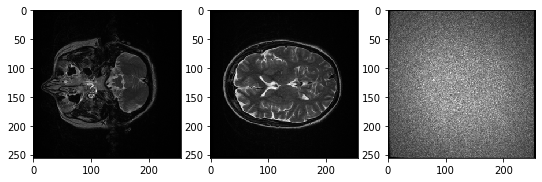

In [ ]:
# Let's print three slices of the axial plane with the slicer
# function we made for you
aip.other.slicer(T2_array)

These are the middle slice, the slice at 1/4 of the axial-direction and the
3/4 slice in the axial direction.

Let us now load the segmentation as well and look at the three segmented slices.

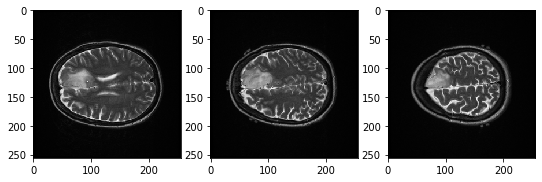

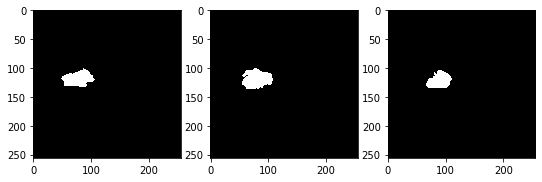

In [ ]:
T2_mask = sitk.ReadImage(LGG_data['LGG-104']['Segmentation_full'])
T2_mask_array = GetArrayFromImageC(T2_mask)
seg_slices = [38, 39, 40]
aip.other.slicer(T2_array, mask=T2_mask_array)
aip.other.slicer(T2_mask_array, mask=T2_mask_array)

We can look at the segmented tumor by simply multiplying the image and
the mask

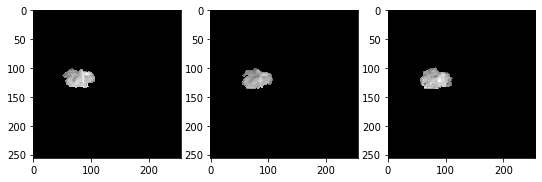

In [ ]:
aip.other.slicer(T2_array*T2_mask_array, seg_slices)

We can extract only these slices from the image with the ```get_masked_slices_image```
function from PREDICT:

In [ ]:
T2_array, T2_mask_array = ih.get_masked_slices_image(T2_array, T2_mask_array)


## 1. Histogram features
We are now going to extract features from the tumor region using the T2
and the mask. First off, we will start with histogram features. We can
use the numpy histogram function to create a histogram. We have to pick
the number of bins ourselves, which we for now will set to 50:


In [ ]:
N_BINS = 50
histogram, bins = np.histogram(T2_array, N_BINS)

You can use the plt.hist() function to directly plt the histogram of
an image, but this will not return the histogram. We are therefore going
to plot it ourselves:

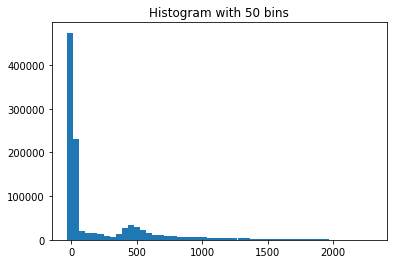

In [ ]:
plt.figure()
plt.bar(bins[:-1], histogram, width=np.max(bins)/N_BINS)
plt.title("Histogram with " + str(N_BINS) + " bins")
plt.show()

**Question 1**: Why is there a large peak at the lowest bin?

To get rid of this undesired peak, we will use the get_masked_voxels
function from PREDICT:

In [ ]:
masked_voxels = ih.get_masked_voxels(T2_array, T2_mask_array)

Now we will create a new histogram without this peak:

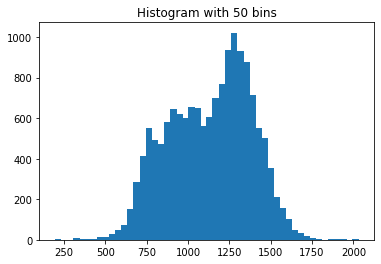

In [ ]:
histogram, bins = np.histogram(masked_voxels, N_BINS)
plt.figure()
plt.bar(bins[:-1], histogram, width=np.max(bins)/N_BINS)
plt.title("Histogram with " + str(N_BINS) + " bins")
plt.show()

We learned in the lecture multiple features that can be extracted from
the histogram, which we call histogram or first order features. Actually,
we do not extract all these features from the histogram, but some can
better be extracted from the feature itself.

**Question 2**: Why is is better to compute some statistics, like the standard
deviation, on the actual image and some on the histogram, like
the peak position?

We have already defined some of the features for you in
the histogram_features.py file.

In [ ]:
# These include the standard deviation of the image:
std = hf.get_std(masked_voxels)

# The skewness and kurtosis of an image:
skewness = hf.get_skewness(masked_voxels)

# And the peak histogram position:
peak = hf.get_peak_position(histogram)

# We can print these values to the console:
print(f'Standard deviation: {std}')
print(f'Skewness: {skewness}')
print(f'Peak: {peak}')

Standard deviation: 248.56429480405828
Skewness: -0.19157024021634408
Peak: 29


**Question 3**: What do the skewness and kurtosis say about a histogram? Hence,
declare why the skewness is -0.19 in this example.


# Exercise 1 - Histogram Features

- **Hand-In Code**: sub-exercise 3.
- **Hand-In Answers**: The generated plots and answers to the questions.

Note: when making the boxplots in these exercises, you might want to use
  the class labels of the patients. These are stored in the ```LGG_labels``` variable we loaded at the start of this notebook.

1. Load and plot the T2 images for two patients with the 1p19q co-deletion and two without. **Question**: what kind of differences between the co-deleted and non co-deleted patients can you spot in the images that could be quantified using histogram features?

2.  Extract all histogram features for the four patients you selected using the
  ```get_histogram_features``` function from PREDICT .
  This function takes as input the (image) data and the number of bins.
  Use the for loop below: you only need to add patient names to imagenames and
  put the correct labels of the patients in the patient_labels object. 


In [ ]:
pids = ['LGG-104', 'LGG-246']
patient_labels = [LGG_labels[pid] for pid in pids]
image_features = list()

# We will save the T2 images and masks in lists so you can use them later
T2_images = list()
T2_masks = list()

for pid in pids:
    # Load the image and mask, plus convert ITK Images to arrays
    image = sitk.ReadImage(LGG_data[pid]['T2_image'])
    image_array = GetArrayFromImageC(image)
    mask = sitk.ReadImage(LGG_data[pid]['Segmentation_full'])
    mask_array = GetArrayFromImageC(mask)

    # Extract only those slices that contain tumor
    image_array, mask_array = ih.get_masked_slices_image(image_array, mask_array)
    masked_voxels_a = ih.get_masked_voxels(image_array, mask_array)

    # Extract features
    features, feature_names = hf.get_histogram_features(masked_voxels_a, 50)

    # Append to a list so we can combine all features from all patients
    image_features.append(dict(zip(feature_names, features)))

    # We will save the T2 images and masks in lists so you can use them later
    T2_images.append(image_array)
    T2_masks.append(mask_array)



3. Plot the features using
  boxplots. **Question** Look at the values: can you explain the differences in feature values among the patients based on what you concluded in point 1?

In [ ]:
# room for your boxplot code

4. Select two features of which you think could be used to distinguish the
   different tumor types you see. Motivate your choice.
   Plot these in a scatter plot for all four patients.
   You can use the following code we made for the minimum and maximum
   features: just change the values of label1 and label2 to the desired
  feature names.

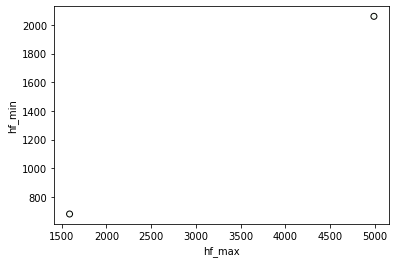

In [ ]:
# Set labels we want to extract
label1 = 'hf_max'
label2 = 'hf_min'

# Extract the feature value with this label for all patients
features_label1 = [f[label1] for f in image_features]
features_label2 = [f[label2] for f in image_features]

# Create a scatterplot of the features
plt.figure()
ax = plt.subplot(1, 1, 1)
ax.scatter(features_label1, features_label2, c=patient_labels,
           cmap=plt.cm.Greens,
           edgecolors='k')
ax.set_xlabel(label1)
ax.set_ylabel(label2)
plt.show()

## 2. Shape Features
The next class we are going to deal with is shape features. Shape features
are solely computed on the mask of the ROI. We do need the actual 3-D matrix
for this, not the flattened 1-D vector. As we saw in the lecture, most of
these features are only defined in 2-D. That's why we will compute the
shape features per 2-D axial slice and put these values in a list.
We can then compute some statistics over these
values, e.g. the mean or the standard deviation over all slices.

We have already defined some of the features for you in
the shape_features.py file, similar to the histogram features. Note that as
we use many SimpleITK functions to compute the shape features, the mask needs
to be supplied as ITK image instead of numpy array!


Let's extract some shape features on a 2-D slice of the T2 mask we previously
loaded. As the third dimension will only contain a single slice, we want
to remove the dimension to end up with a 2D array. The numpy squeeze
function will remove any dimension which equals one:


In [ ]:
T2_mask_slice = np.squeeze(T2_mask_array[:, :, 0])

# For a conversion back to an ITK image, the uint8 type is required:
T2_mask_slice = T2_mask_slice.astype(np.uint8)
T2_mask_slice = sitk.GetImageFromArray(T2_mask_slice)

Many of the features do not need the full contour, but only the boundary
points of the contour. Some boundaries are not smooth and miss points.
A convex hull can be used to solve this issue, as we saw in the lectures. To
this end, we use the get_smooth_contour
function from the ```contour_functions``` functions:

In [ ]:
# Set minimum and maximum contour sizes: you don't need to adjust these in the exercise
N_min = 10
N_max = 40
boundary_points = cf.get_smooth_contour(T2_mask_slice, N_min, N_max)


**Question 4**: What does the boundary_points object contain? Plot the boundary
points on the original mask by using
```plt.plot(boundary_points[:,0], boundary_points[:,1])```.
Did the function do what you expected?

In [ ]:
# Now we can compute some features. These include the circular variance:
cvar = sf.compute_cvar(boundary_points)

# and the area of the mask:
area = sf.compute_area(boundary_points)

# and the eliptical variance
evar = sf.compute_evar(boundary_points)

# We can print these values to the console:
print(cvar, area, evar)

0.0585686326584399 542.0 0.025059157443185053


# Exercise 2 - Shape Features

- **Hand-In Code**: sub-exercise 2.
- **Hand-In Answers**: The generated plots and answers to the questions.

1. Use the code below to run the ```create_images``` function from the
  aip package to generate images containing a circle, a square
  and a triangle and plot them. **Question:** Which shape features do you think would be
  useful to distinguish these different shapes from each other? Note
  that these images are given as ITKImage types!

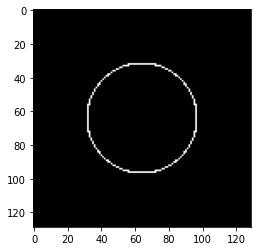

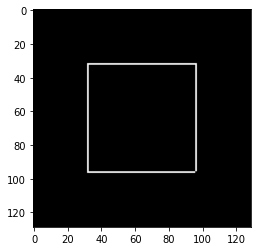

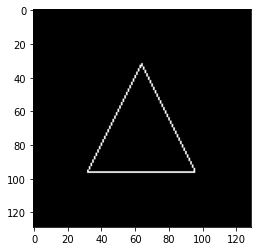

In [ ]:
circle, square, triangle = aip.other.create_images()
plt.figure()
plt.imshow(sitk.GetArrayFromImage(circle), cmap='gray')
plt.figure()
plt.imshow(sitk.GetArrayFromImage(square), cmap='gray')
plt.figure()
plt.imshow(sitk.GetArrayFromImage(triangle), cmap='gray')

2. Compute all shape features on these images with the
get_shape_features function from the ```sf``` funtion we previously imported. *Note*: the ```get_shape_features``` function needs an ITKImage type as input! Make a barplot
of all features. **Question:** Do they meet your expectations from the previous question? Please explain why (not).


In [ ]:
# Room for your code on sub-exercise 2

# Hint: Remove/pop the area features as this is of another order, so the scaling is very different from the others so you cannot see those in the boxplot

3. Extract all shape features from the T2 masks from the four patients
  you loaded in the previous exercise. Plot the features using
  barplots. Use the for loop below. **Question:** Look at the values: can you explain the most noticable
  differences in feature values among the patients by looking at the
  images and/or masks?

Mask for patient: LGG-104
Mask for patient: LGG-246


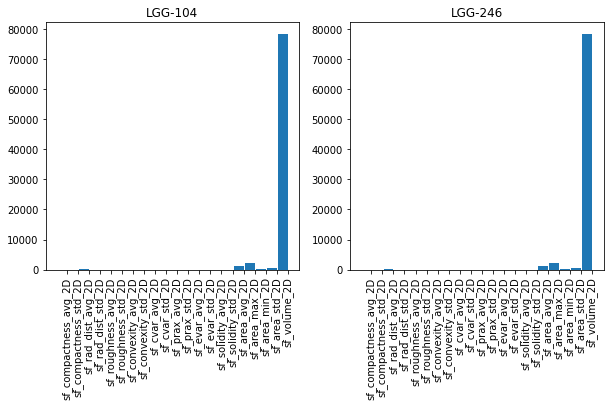

In [ ]:
# Initialize figure
fig = plt.figure(figsize=(10, 10))
bar_width = 0.9

# Set the patient names and patient labels you are going to use
imagenames = ['LGG-104', 'LGG-246']
patient_labels = [LGG_labels[pid] for pid in pids]

image_features = list()
for num, imname in enumerate(imagenames):
    print("Mask for patient: " + imname)
    # Read the mask and convert to array
    mask = sitk.ReadImage(LGG_data[pid]['Segmentation_full'])
    mask_array = GetArrayFromImageC(mask)

    # Select only the slices that contain tumor, now only from the mask
    mask = ih.get_masked_slices_mask(mask)

    # Extract shape features
    feature_values, feature_labels = sf.get_shape_features(mask)

    # Pop the volume feature as it's out of scale with the rest
    feature_values.pop(-1)
    feature_labels.pop(-1)

    # Plot the features
    x = np.arange(len(feature_values))  # x-values to create bars at
    ax = fig.add_subplot(2, 2, num + 1)
    ax.bar(x, feature_values, width=bar_width)
    ax.set_xticks(x + (bar_width/2.0))
    ax.set_xticklabels(feature_labels, rotation=90)
    ax.set_title(imname)
    image_features.append(dict(zip(feature_labels, feature_values)))


4. Select two features of which you think could be used to distinguish the
   different tumor types you ses. **Question:** Motivate your choice. Plot these in
   a scatter plot for all four patients. Explain whether the results are as expected or not. Hint: use your code from Exercise 1,
   part 4 four this.

In [ ]:
# Your code for exercise 4

## 3. Texture features
The last class we will adress are texture features. We will cover
three topics:

1. Gabor filter features
2. Gray Level Co-occurence Matrix (GLCM) features
3. Local Binary Pattern (LBP) features



# 3.1 Gabor features
As we saw in the lecture, Gabor features can be created by applying a Gabor
filter to an image and computing some statistics afterwards. Let's use
an example image from the skimage package to see what the Gabor filter does:


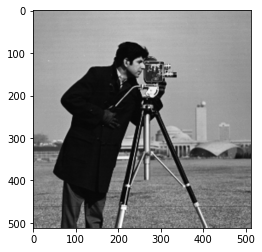

In [ ]:
cameraman = data.camera()
plt.figure()
plt.imshow(cameraman, cmap='gray')

skimage already has the gabor filter implemented. Look at the help of the
function now: you can specificy multiple arguments to configure the Gabor
kernel used for filtering. The frequency is mandatory: let's just set
it to 0.2 pixels to start with. The function will return two arrays,
containing the real and the imaginary part. Let us visualize
both and also the enerqy, defined as the square root of the sum
of squares. As we will reuse thise, we will make a function out of it:


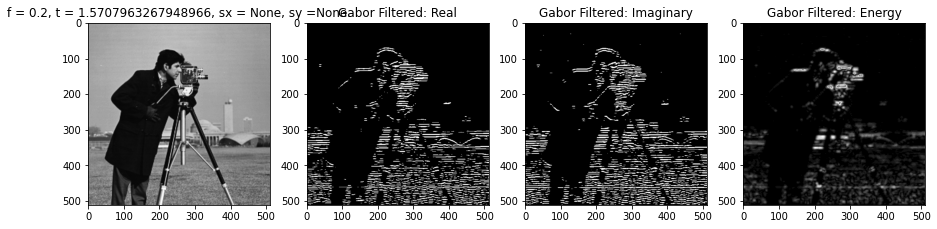

In [ ]:
def plot_gabor_filter(image, fr=0.2, theta=0.5*np.pi, sigma_x=None, sigma_y=None):
    # Apply gabor filter
    real, imag = skimage.filters.gabor(image, frequency=fr,
                                       theta=theta, sigma_x=sigma_x,
                                       sigma_y=sigma_y)

    # Compute the energy
    energy = np.sqrt(real**2 + imag**2).astype(np.uint8)

    # Plot the real, imaginary compontents and energy in a single figure
    f = plt.figure(figsize=(15, 20))
    ax = f.add_subplot(1, 4, 1)
    ax.imshow(image, cmap='gray')
    title = ('f = {}, t = {}, sx = {}, sy ={}.').format(str(fr),
                                                        str(theta),
                                                        str(sigma_x),
                                                        str(sigma_y))
    ax.set_title(title)
    ax = f.add_subplot(1, 4, 2)
    ax.imshow(real, cmap='gray', vmin=np.min(real), vmax=np.max(real))
    ax.set_title('Gabor Filtered: Real')
    ax = f.add_subplot(1, 4, 3)
    ax.imshow(imag, cmap='gray', vmin=np.min(imag), vmax=np.max(imag))
    ax.set_title('Gabor Filtered: Imaginary')
    ax = f.add_subplot(1, 4, 4)
    ax.imshow(energy, cmap='gray', vmin=np.min(energy), vmax=np.max(energy))
    ax.set_title('Gabor Filtered: Energy')


plot_gabor_filter(cameraman)

**Question 5**: What can you see in the three different results? Remember what
          texture pattern the Gabor feature is targetting from the lecture!


# Exercise 3 - Gabor Features


- **Hand-In Code**: none.
- **Hand-In Answers**: The generated plots and answers to the questions.

 1. Extract the Gabor feature for various settings: frequency, angle, but
   also the standard deviations of the gaussian filter in both directions
   (sigma_x and sigma_y) and plot the results. Hint: use the for loop
   as given below, but use some more values:

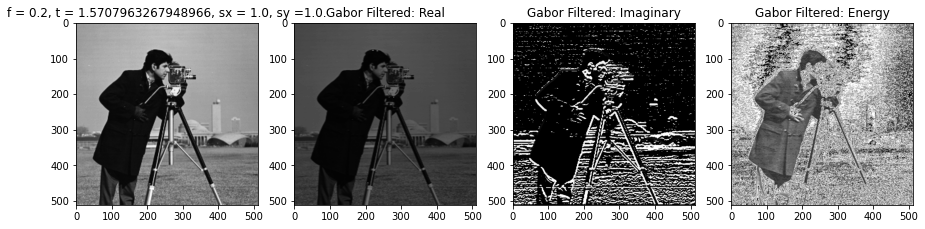

In [ ]:
thetas = [0.5*np.pi]
freqs = [0.2]
sigmas_x = [1.0]
sigmas_y = [1.0]
for x, y in zip(sigmas_x, sigmas_y):
    for t, fr in zip(thetas, freqs):
        plot_gabor_filter(cameraman, fr, t, x, y)


**Question:** How do these parameters influence the result of the filter? There
are infinitely many options to chose from, but you have to pick a few
in order to not compute too many features. Please state which values of the parameters you used in your answer to support your claims.

2. Filter one of the T2 images from the previous exercises with a
   Gabor filter which you think will give a high response. **Questions**: Motivate
   your choice of parameters based on what you found in the previous
   exercise. Note: You only have to apply the filter to a single axial
   slice. Does it give a response we can use to extract useful features from?


In [ ]:
# Your code for exercise 2

**NOTE:** From now on (so not in exercise 3), for extracting Gabor features,
you can use the gabor_filter_parallel function from the
texture_features script.

# 3.2 Gray Level Co-occurence Matrix (GLCM)
Another texture feature is the GLCM. As the name says, the feature is based
on a gray level matrix. Technically, our image is already a matri
consisting of gray levels. Hence we could straight forwardly just compute
the GLCM. Skimage also provides us with a function to compute the GLCM.
The parameters you have to set are 1) the distance between
co-ocurring pixels, 2) the angles in which to look for co-ocurrences and
3) the number of gray levels used.

In [ ]:
GLCM_matrix = greycomatrix(cameraman, distances=[10], angles=[0])

**Question 6**: why do you need discretization in a number of levels in the GLCM?


The result will be a 4-D matrix with dimensions [levels, levels,
distances, angles]. Hence the function will output a single 2D GLCM
for each distance and angle setting with the size of the number of
levels and stack them in a 4D array. As we only provided the function
with a single distance and angle, the last two dimensions are equal to
one. The function has set the number of levels equal to the number
of different values in the image, which is apparantly 256.



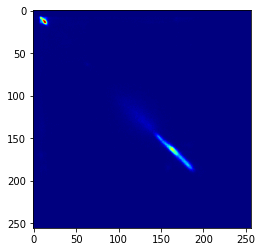

In [ ]:
# Plot the GLCM matrix just like an image:
plt.figure()
plt.imshow(GLCM_matrix[:, :, 0, 0],
           vmin=0, vmax=np.max(GLCM_matrix[:, :, 0, 0]), cmap='jet')

As you can see, the matrix is not that informative: only a couple of values
co-occur numerous times.

Hence, the image is often first discretized in a number of bins,
similar to how we created a histogram. Skimage also provides a function for
this purpose, called rescale_intensity.

Text(0.5, 1.0, 'Rescaled: 8 levels')

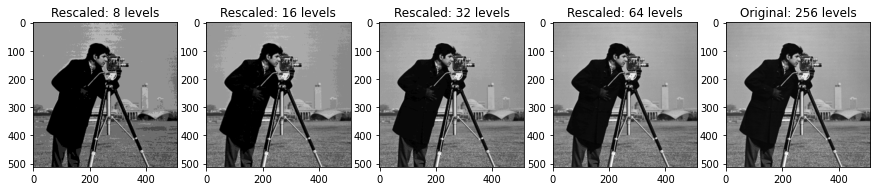

In [ ]:
# Let's rescale the intensity to a couple of different levels
im_8 = rescale_intensity(cameraman, out_range=(0, 7))
im_16 = rescale_intensity(cameraman, out_range=(0, 15))
im_32 = rescale_intensity(cameraman, out_range=(0, 31))
im_64 = rescale_intensity(cameraman, out_range=(0, 63))

# Let's plot the rescaled images to see the impact
f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(1, 5, 5)
ax.imshow(cameraman, cmap='gray',
          vmin=np.min(cameraman), vmax=np.max(cameraman))
ax.set_title('Original: 256 levels')
ax = f.add_subplot(1, 5, 4)
ax.imshow(im_64, cmap='gray', vmin=np.min(im_64), vmax=np.max(im_64))
ax.set_title('Rescaled: 64 levels')
ax = f.add_subplot(1, 5, 3)
ax.imshow(im_32, cmap='gray', vmin=np.min(im_32), vmax=np.max(im_32))
ax.set_title('Rescaled: 32 levels')
ax = f.add_subplot(1, 5, 2)
ax.imshow(im_16, cmap='gray', vmin=np.min(im_16), vmax=np.max(im_16))
ax.set_title('Rescaled: 16 levels')
ax = f.add_subplot(1, 5, 1)
ax.imshow(im_8, cmap='gray', vmin=np.min(im_8), vmax=np.max(im_8))
ax.set_title('Rescaled: 8 levels')

You can see that much of the detail is still preserved when reducing the
the number of gray levels. Even with only 8 different values left,
you can still easily make out the different objects in the image. However,
much of the details get lost: for example, the grassy pattern and the
windows in the flat in the background.

Therefore, the number of levels you use can have a major influence on your
GLCM features. Let's visualize that. We will use an enumerate loop for
this purpose: this will both loop over the item we provide, but
also provide us with the number of the iteration in the loop.


Text(0.5, 1.0, 'Original GLCM: 256 levels')

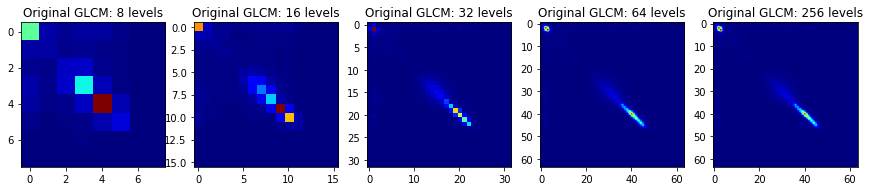

In [ ]:
# Visualize GLCM for various discretization levels
f = plt.figure(figsize=(15, 15))
images = [im_8, im_16, im_32, im_64]

for num, image in enumerate(images):
    # Note: make sure to set the number of levels correctly!
    levels = 2**(3 + num)

    # Extract GCLM features
    GLCM_matrix = greycomatrix(image, distances=[10],
                               angles=[0], levels=levels)

    # Plot the GLCM
    ax = f.add_subplot(1, 5, num + 1)
    ax.imshow(GLCM_matrix[:, :, 0, 0], vmin=0,
              vmax=np.max(GLCM_matrix[:, :, 0, 0]), cmap='jet')
    titlestring = ('Original GLCM: {} levels').format(str(levels))
    ax.set_title(titlestring)

# Let's add the original GLCM also to the figure
ax = f.add_subplot(1, 5, 5)
ax.imshow(GLCM_matrix[:, :, 0, 0], vmin=0,
          vmax=np.max(GLCM_matrix[:, :, 0, 0]), cmap='jet')
ax.set_title('Original GLCM: 256 levels')

You will see that we we roughly observe the same pattern for all gray levels
for this specific image. We are more robust to noise, which we will
see later. However, the amount of detail we obtain gets smaller when
decreasing the number of gray levels.

Which number of levels (and which distances and angles) to use,
varies per application. You should at least use the same settings on each
patient.

**Question 7**: how does the number of levels influence the GLCM? Which number of
          levels do you think is most suitable for this image?
          And for a T2 MR? Motivate your choices.


# Gray Level Matrix Features
We will use the image with 16 levels to compute several GLCM on, with
various distances and angles. Additionally, we will normalize the GLCM, such
that all values are between [0, 1] with the "normed" parameter.


In [ ]:
levels = 16

**Question 8**: Why would we prefer to use a normalized GLCM? Hint: we would
           ultimately like to distinguish different classes based on GLCM
           features. What is the influence of normalization on this task?


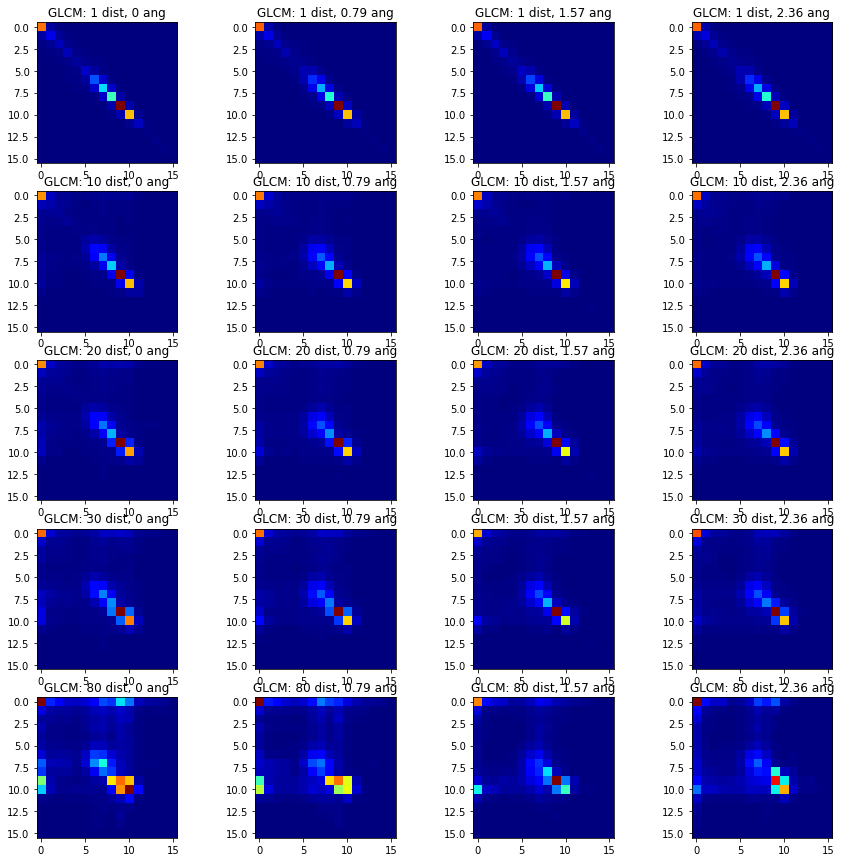

In [ ]:
# Let's extract the GLCM for several angles and distances
distances = [1, 10, 20, 30, 80]
angles = [0, 0.79, 1.57, 2.36]  # In radians
GLCM_matrix = greycomatrix(im_16, distances=distances,
                           angles=angles, levels=levels, normed=True)

# Let's plot the matrix. We will use a zip for loop to loop over two lists:
# the indices of the distances and those of the angles.
f = plt.figure(figsize=(15, 15))
num = 0
for num_dist in range(0, len(distances)):
    for num_ang in range(0, len(angles)):
        ax = f.add_subplot(5, 4, num+1)
        ax.imshow(GLCM_matrix[:, :, num_dist, num_ang], vmin=0,
                  vmax=np.max(GLCM_matrix[:, :, num_dist, num_ang]),
                  cmap='jet')
        d = distances[num_dist]
        a = angles[num_ang]
        titlestring = ('GLCM: {} dist, {} ang').format(str(d), str(a))
        ax.set_title(titlestring)
        num += 1

We see different patterns for different distances and angles. As seen in the
lecture, we can now extract different properties from the GLCM matrix.
Skimage has already defined several of these features in the greycoprops
function, which we are also going to use:

In [ ]:
# Extract various GLCM features
contrast = greycoprops(GLCM_matrix, 'contrast')
dissimilarity = greycoprops(GLCM_matrix, 'dissimilarity')
homogeneity = greycoprops(GLCM_matrix, 'homogeneity')
ASM = greycoprops(GLCM_matrix, 'ASM')
energy = greycoprops(GLCM_matrix, 'energy')
correlation = greycoprops(GLCM_matrix, 'correlation')

All properties are extracted for every distance and angle setting there is in
the GLCM, resulting in a 2D matrix of 5x4 in this case. We can see that these
features are quite different per angle and distance, for example
the contrast:


In [ ]:
print(contrast)

[[ 0.53535882  0.81532316  0.3541845   0.74352503]
 [ 6.3013454   6.22852662  4.78648297  5.92340359]
 [ 9.54048368  9.58847035  7.859375    8.68907356]
 [11.78541559 12.16204512  9.98675765 10.82149153]
 [21.12875253 22.27553981 16.43075448 17.03708309]]


We may now use these properties as features to distinguish between
different classes. To this end, we will execute the following example
from skimage on the GLCM matrix, which can also be found at
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html.

In this example, we extract four patches of the sky from the cameraman
image and four grassy patches. By computing the GLCM in a small neighboorhood
around each pixel, we can distinguish these patches. Or rather, the central
pixel of the patch. We can thus classify pixels if they belong to the grass
or the sky.


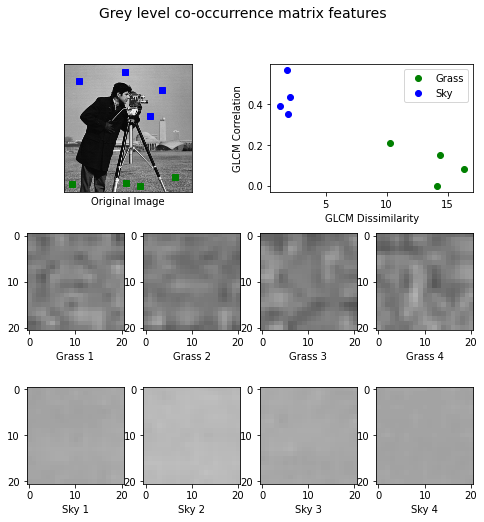

In [ ]:
# Example of distinguishing patches using GLCM features
PATCH_SIZE = 21

# open the camera image
image = data.camera()

# select some patches from grassy areas of the image
grass_locations = [(474, 291), (440, 433), (466, 18), (462, 236)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
sky_locations = [(54, 48), (21, 233), (90, 380), (195, 330)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in sky_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Sky')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(sky_patches):
    ax = fig.add_subplot(3, len(sky_patches), len(sky_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Sky %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()

You can see that the grass patches have a high GLCM dissimilarity (there are
quite some different values present) while having a low correlation. The
opposite holds for the patches from the sky, which display a more
homogenous pattern.

## Exercise 4 - GLCM features

- **Hand-In Code**: Everything.
- **Hand-In Answers**: The generated plots and answers to the questions.

Compute the GLCM features we just encountered for the four T2 images
you loaded previously. Again, you only need to use a single slice per
patient. You may use the get_GLCM_features function from the
PREDICT ```tf``` function for this end.

**Question:** Try to find some reasonable values for the number of levels, the distances
and the angles used and explain your choices. 

Plot the features in
boxplots similar to done in Exercise 1 and 2.

**Question:**  Can you explain which
features would be useful to distinguish between the classes and why?


In [ ]:
# Your code for exercise four. Note that the tf.get_GLCM_features function
# as the third input takes a dictionary, which should contain
# the value for which the GLCM should be computed. For example:
levels = 16
distances = [1]
angles = [np.pi]
parameters = {'levels': levels, 'angles': angles, 'distances': distances}


## 3.3 Local Binary Patterns
The last texture feature class we will discuss are local binary patterns.
Again, skimage has already implemented this feature. The parameters you
have to set are the radius and the number of points used.

**Question 9**: How do the number of points used and the radius relate to
          eachother? What number of points would you use for e.g.
          a radius of 1, 3 and 8 pixels?

Let us start out with an example using the LBP "filter" on our cameraman
image. While computing an LBP is more than a mere filtering operation
with a kernel, the result can be seen as a filtered version of the
original image.

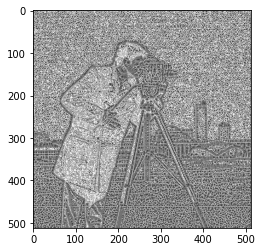

In [ ]:
# LBP example
method = 'uniform'
radius = 1
N_points = 8
LBP_image = local_binary_pattern(cameraman, P=N_points,
                                 R=radius, method=method)
plt.figure()
plt.imshow(LBP_image, cmap='gray')

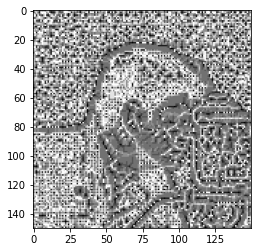

In [ ]:
# As the different values are a little difficult to distinguish, let's focus
# on the head of the cameraman.
head = LBP_image[50:200, 150:300]
plt.figure()
plt.imshow(head, cmap='gray')

We see that the homogeneous parts of the image, such as the coat of the
cameraman and the sky, result in random patterns. This is due to the
small variations in the intensities. Actual structures, like the outline of
both the cameraman and the camera, result in very specific patterns. These
patterns could be used as features to disintguish between objects.



Let's now compute the LBP for our T2 image of the tumor. As the
LBP function from skimage is only defined in 2-D, we will only use a
single slice. We largely follow the example from skimage:
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html


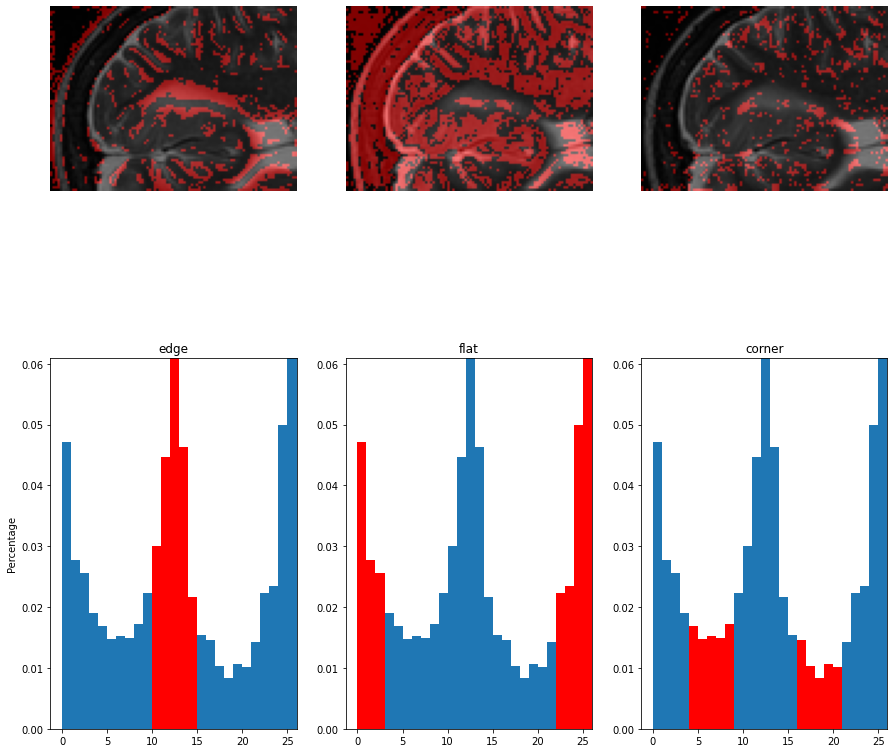

In [ ]:
# Example of LBP computation on a T2 slice
T2_slice = T2_array[:, :, 1].copy()

# Convert the slice to uint8: add the minimum, normalize to [0, 1]
# and scale to [0. 255]
T2_slice += np.min(T2_slice)
T2_slice /= np.max(T2_slice)
T2_slice = (T2_slice*255).astype(np.uint8)

# We zoom in on the tumor
T2_slice = T2_slice[75:150, 25:125]

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


lbp = local_binary_pattern(T2_slice, n_points, radius, 'uniform')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), bins=n_bins, range=(0, n_bins),
                   density='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(T2_slice, lbp, labels),
              vmin=np.min(T2_slice), vmax=np.max(T2_slice))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(ymax=np.max(counts[:-1]))
    ax.set_xlim(xmax=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

The LBP images are not that easy to interpret. The separation applied in the
flat, edge and corner patterns is rather arbitrary and depends on the image.
The real important factor is that you will want these features to have
different values for different structures. This will determine which
parameter settings you need to use.

# Exercise 5 - LBP features

- **Hand-In Code**: none.
- **Hand-In Answers**: The generated plots and answers to the questions.

1. Compute the LBP features we just encountered for the four T2 images we loaded. You can use the following example code:

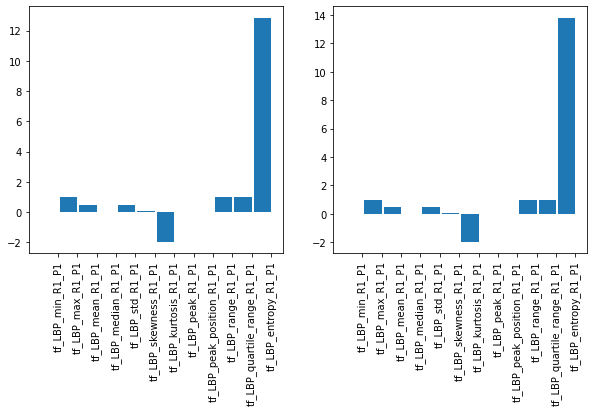

In [ ]:
# Set parameters
radius = [1]
N_points = 3
parameters = {'radius': radius, 'N_points': N_points}

# Create a figure for plotting and a list for the features
fig = plt.figure(figsize=(10, 10))
bar_width = 0.9
image_features = list()

# Loop over the images and masks
for num, (i, m) in enumerate(zip(T2_images, T2_masks)):
    # Extract LBP Features
    a_sf, a_sl = tf.get_LBP_features(i, m, parameters)

    # We remove the range feature, as it messes up the scaling of the figure
    a_sf.pop(10)
    a_sl.pop(10)

    # Plot the feature values
    x = np.arange(len(a_sf))
    ax = fig.add_subplot(2, 2, num + 1)
    ax.bar(x, a_sf, width=bar_width)
    ax.set_xticks(x + (bar_width/2.0))
    ax.set_xticklabels(a_sl, rotation=90)

    # Append features to list for all patients
    image_features.append(dict(zip(a_sl, a_sf)))

plt.show()

**Question:** Try to find some reasonable values for the radius
and the angles used and explain your choices. Plot the features
in boxplots similar to done in Exercise 1 and 2. Can you explain
which features would be useful to distinguish between the classes and why?


2. **Question:** Plot the two features you think are most useful for
   distinguishing different tumor types in a scatter plot. Do they indeed    show a good seperation line?

In [ ]:
# Your code for exercise 2